<a href="https://colab.research.google.com/github/madhurlak0810/SEC-edgar/blob/master/Project_602_Checkpoint_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Checkpoint 2***

**Data Processing and Data Cleaning**
We have imported the data from sec.gov api endpoint, the end point provides information regarding company tickers.
Inoformation of companies with following information:
1. listed in nasdaq with in the technology sector
2. an active IPO year having a market cap > 1 Mil
3. Country is USA and volume of shares greater than 1000
has been gathered from nasdaq.

Finally a companies_considered dataframe is filtered and created.

CIK or unique identifier from sec edgar is used to lookup company information as gathered from nasdaq.

After matching the company information with the cik lookup, we get further information regarding interested companies using another api endpoint 'companyfacts'

The result of this api contains different parameters regarding the company and with filing information about when they were filed.

Data_list contians the list of most relevant parameters which are present across multiple companies chosen for analysis.

Finally, all relevant information is merged with parameters transposed to create a dataframe required for further analysis.

**Basic data exploration and summary statistics**

Pandas describe function is used to get a summary information about the created dataframe and missing value information is dispalyed across all present columns

*Statistical methods applied*

1. Correlation Matrix
- We use this to present a correlation between all the parameters we are interested in.
2. Hypothesis Testing
- Null Hypothesis: Increased share-based compensation is associated with higher growth in stockholders' equity
- Share-Based Compensation and Equity Growth Hypothesis
3. Regression Analysis
- This explores the relationship between Allocated Share-Based Compensation Expense (treated as a proxy for R&D expenses) and Stockholders' Equity Growth. The primary goal is to determine how changes might impact stockholders' equity over time.
4. Anova Testing
- Analysis of Variance (ANOVA) is conducted to test statistical significance between Allocated Share-Based Compensation Expense (R&D) and Stockholders' Equity Growth. We aim to determine if the means of these two metrics differ.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from bs4 import BeautifulSoup

In [2]:
# Define the URL for the SEC EDGAR search page
url = "https://www.sec.gov/files/company_tickers_exchange.json"

headers = {
   "User-Agent": "your.email@email.com"
}
# Fetch the HTML content of the search page
response = requests.get(url,headers=headers)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

In [3]:
# Parse the JSON content from the BeautifulSoup object
json_data = json.loads(soup.text)

# Convert the JSON data into a pandas DataFrame
df_cik_lookup = pd.DataFrame(json_data['data'], columns=json_data['fields'])


# df_cik_lookup['cik']=df_cik_lookup['cik'].astype(str).zfill(10)
df_cik_lookup

,cik,name,ticker,exchange
0,320193,Apple Inc.,AAPL,Nasdaq
1,789019,MICROSOFT CORP,MSFT,Nasdaq
2,1045810,NVIDIA CORP,NVDA,Nasdaq
3,1652044,Alphabet Inc.,GOOGL,Nasdaq
4,1018724,AMAZON COM INC,AMZN,Nasdaq
...,...,...,...,...
10162,2024203,Cayson Acquisition Corp,CAPNU,Nasdaq
10163,2025065,Black Spade Acquisition II Co,BSIIU,Nasdaq
10164,2025065,Black Spade Acquisition II Co,BSIIW,Nasdaq
10165,2025341,Andretti Acquisition Corp. II,POLEU,Nasdaq


In [4]:
df_cik_lookup.head()

,cik,name,ticker,exchange
0,320193,Apple Inc.,AAPL,Nasdaq
1,789019,MICROSOFT CORP,MSFT,Nasdaq
2,1045810,NVIDIA CORP,NVDA,Nasdaq
3,1652044,Alphabet Inc.,GOOGL,Nasdaq
4,1018724,AMAZON COM INC,AMZN,Nasdaq


Get a list of companies listed in NASDAQ, filter for Technology companies with an active IPO year, market cap > 1 Mil, Country is USA and volume of shares is greater than 1000

In [5]:

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('nasdaq_screener_1729013554057.csv')

# Convert the 'IPO Year' column to integer format, handling potential errors
df['IPO Year'] = pd.to_numeric(df['IPO Year'], errors='coerce').astype('Int64')


# Filter the DataFrame based on the specified criteria
filtered_df = df[(df['Country'] == 'United States') &
                 (df['Sector'] == 'Technology') &
                 (df['IPO Year'].notna()) &
                 (df['Market Cap'] > 1000000) &
                 (df['Volume'] >= 1000)]

filtered_df = filtered_df[~filtered_df['Name'].str.contains('warrant', case=False)]

# Sort the DataFrame in descending order based on 'Market Cap' and select the top 50
filtered_df = filtered_df.sort_values('Market Cap', ascending=False).head(50)


columns_to_remove = ['Last Sale', 'Net Change', 'Unnamed: 8', '% Change', 'Volume', 'Sector']

# Remove the specified columns from the DataFrame
companies_considered = filtered_df.drop(columns=columns_to_remove, errors='ignore')

# assign a new index starting from 1
companies_considered.index = np.arange(1, len(companies_considered) + 1)

print(companies_considered)

   Symbol                                               Name    Market Cap  \
1    AAPL                            Apple Inc. Common Stock  3.563394e+12   
2    NVDA                    NVIDIA Corporation Common Stock  3.220298e+12   
3    MSFT                 Microsoft Corporation Common Stock  3.105449e+12   
4    GOOG                Alphabet Inc. Class C Capital Stock  2.062048e+12   
5   GOOGL                 Alphabet Inc. Class A Common Stock  2.044937e+12   
6    META           Meta Platforms Inc. Class A Common Stock  1.481562e+12   
7    AVGO                         Broadcom Inc. Common Stock  8.214609e+11   
8    ORCL                    Oracle Corporation Common Stock  4.836170e+11   
9     CRM                       Salesforce Inc. Common Stock  2.773834e+11   
10   ADBE                            Adobe Inc. Common Stock  2.244382e+11   
11   QCOM                 QUALCOMM Incorporated Common Stock  1.943373e+11   
12    NOW                       ServiceNow Inc. Common Stock  1.

In [6]:

# Perform an inner join on 'ticker' and 'Symbol' columns
merged_df = pd.merge(df_cik_lookup, companies_considered, left_on='ticker', right_on='Symbol', how='inner')

# Print the merged DataFrame
print(merged_df.columns)

Index(['cik', 'name', 'ticker', 'exchange', 'Symbol', 'Name', 'Market Cap',
       'Country', 'IPO Year', 'Industry'],
      dtype='object')


In [7]:
def make_edgar_request(url):
    """
    Make a request to EDGAR (Electronic Data Gathering, Analysis and Retrieval)
    :param url: request URL
    :return: response
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36",
        "Accept-Encoding": "gzip, deflate, br",
    }
    return requests.get(url, headers=headers)

In [8]:
def get_company_data(cik):
  """Fetches and processes data for a given CIK."""

  url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{str(cik).zfill(10)}.json"
  header = {
    "User-Agent": "your.email@email.com"  # Replace with your actual email
  }

  response = requests.get(url, headers=header)

  if response.status_code == 200:
    data = response.json()

    us_gaap_data = data.get("facts", {}).get("us-gaap", {})
    table_data = []

    for concept, values in us_gaap_data.items():
      for value in values.get("units", {}).get("USD", []):
        if "val" in value:
          table_data.append([concept, value.get("val"), value.get("fy"), value.get("fp")])

    df = pd.DataFrame(table_data, columns=["Concept", "Value", "Fiscal Year", "Fiscal Period"])
    entity_name = data.get("entityName", "Unknown")  # Get the entity name
    df["entityName"] = entity_name  # Add entity name as a column
    df["cik"] = cik  # Add CIK as a column
    return df
  else:
    print(f"Error: {response.status_code}")
    return None

In [9]:
data_list = [
    "AccountsPayableCurrent",
    "AllocatedShareBasedCompensationExpense",
    "Assets",
    "AssetsCurrent",
    "CashAndCashEquivalentsAtCarryingValue",
    "ComprehensiveIncomeNetOfTax",
    "CurrentFederalTaxExpenseBenefit",
    "CurrentStateAndLocalTaxExpenseBenefit",
    "DeferredFederalIncomeTaxExpenseBenefit",
    "IncomeTaxExpenseBenefit",
    "LesseeOperatingLeaseLiabilityPaymentsDueNextTwelveMonths",
    "LiabilitiesAndStockholdersEquity",
    "LiabilitiesCurrent",
    "NetIncomeLoss",
    "OperatingIncomeLoss",
    "OperatingLeasePayments",
    "PropertyPlantAndEquipmentGross",
    "PropertyPlantAndEquipmentNet",
    "ShareBasedCompensation",
    "StockholdersEquity",
    "UnrecognizedTaxBenefits"
]

In [10]:


# Get a list of CIKs from the merged DataFrame
CIKs_to_process = merged_df["cik"].tolist()

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

for CIK in CIKs_to_process:
  company_df = get_company_data(CIK)
  if company_df is not None:
    combined_df = pd.concat([combined_df, company_df], ignore_index=True)

combined_df.head()



<ipython-input-10-8a3225b5cd93>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, company_df], ignore_index=True)


,Concept,Value,Fiscal Year,Fiscal Period,entityName,cik
0,AccountsPayable,5.520000e+09,2009,Q3,Apple Inc.,320193
1,AccountsPayable,4.854000e+09,2009,Q3,Apple Inc.,320193
2,AccountsPayableCurrent,5.520000e+09,2009,FY,Apple Inc.,320193
3,AccountsPayableCurrent,5.520000e+09,2009,FY,Apple Inc.,320193
4,AccountsPayableCurrent,5.601000e+09,2009,FY,Apple Inc.,320193


In [11]:
df_concepts = pd.DataFrame(data_list, columns=['Concept'])

In [12]:
df_concepts

,Concept
0,AccountsPayableCurrent
1,AllocatedShareBasedCompensationExpense
2,Assets
3,AssetsCurrent
4,CashAndCashEquivalentsAtCarryingValue
5,ComprehensiveIncomeNetOfTax
6,CurrentFederalTaxExpenseBenefit
7,CurrentStateAndLocalTaxExpenseBenefit
8,DeferredFederalIncomeTaxExpenseBenefit
9,IncomeTaxExpenseBenefit


In [13]:
# Perform a join on 'concepts' and 'Concept' columns
joined_df = pd.merge(df_concepts, combined_df, left_on='Concept', right_on='Concept', how='inner')

print(joined_df)

                       Concept         Value Fiscal Year Fiscal Period  \
0       AccountsPayableCurrent  5.520000e+09        2009            FY   
1       AccountsPayableCurrent  5.520000e+09        2009            FY   
2       AccountsPayableCurrent  5.601000e+09        2009            FY   
3       AccountsPayableCurrent  5.601000e+09        2010            Q1   
4       AccountsPayableCurrent  5.601000e+09        2009            FY   
...                        ...           ...         ...           ...   
87208  UnrecognizedTaxBenefits  9.438000e+09        2023            FY   
87209  UnrecognizedTaxBenefits  9.400000e+09        2024            Q1   
87210  UnrecognizedTaxBenefits  9.400000e+09        2024            Q2   
87211  UnrecognizedTaxBenefits  1.020000e+10        2024            Q1   
87212  UnrecognizedTaxBenefits  1.070000e+10        2024            Q2   

          entityName      cik  
0         Apple Inc.   320193  
1         Apple Inc.   320193  
2         Apple

In [14]:

# Filter for Fiscal Period = FY
filtered_joined_df = joined_df[joined_df['Fiscal Period'] == 'FY']

# Make the data unique based on concept, fiscal year, and entityName
unique_df = filtered_joined_df.drop_duplicates(subset=['Concept', 'Fiscal Year', 'entityName'])

print(unique_df)

                       Concept         Value Fiscal Year Fiscal Period  \
0       AccountsPayableCurrent  5.520000e+09        2009            FY   
7       AccountsPayableCurrent  5.601000e+09        2010            FY   
15      AccountsPayableCurrent  1.201500e+10        2011            FY   
23      AccountsPayableCurrent  1.463200e+10        2012            FY   
33      AccountsPayableCurrent  2.117500e+10        2013            FY   
...                        ...           ...         ...           ...   
87095  UnrecognizedTaxBenefits  2.100000e+06        2019            FY   
87096  UnrecognizedTaxBenefits  2.100000e+06        2020            FY   
87099  UnrecognizedTaxBenefits  8.400000e+06        2021            FY   
87102  UnrecognizedTaxBenefits  5.180000e+07        2022            FY   
87108  UnrecognizedTaxBenefits  1.207000e+08        2023            FY   

         entityName      cik  
0        Apple Inc.   320193  
7        Apple Inc.   320193  
15       Apple Inc

In [15]:

# Assuming 'unique_df' is the DataFrame you want to transpose
transposed_df = unique_df.pivot_table(index=['cik', 'entityName', 'Fiscal Year'], columns='Concept', values='Value', aggfunc='first')

# Reset the index to make 'cik', 'entityName', and 'Fiscal Year' regular columns
transposed_df = transposed_df.reset_index()

print(transposed_df)

Concept      cik                  entityName  Fiscal Year  \
0           6951   APPLIED MATERIALS INC /DE         2009   
1           6951   APPLIED MATERIALS INC /DE         2010   
2           6951   APPLIED MATERIALS INC /DE         2011   
3           6951   APPLIED MATERIALS INC /DE         2012   
4           6951   APPLIED MATERIALS INC /DE         2013   
..           ...                         ...          ...   
492      1781335  OTIS WORLDWIDE CORPORATION         2022   
493      1781335  OTIS WORLDWIDE CORPORATION         2023   
494      1835632     MARVELL TECHNOLOGY, INC         2022   
495      1835632     MARVELL TECHNOLOGY, INC         2023   
496      1835632     MARVELL TECHNOLOGY, INC         2024   

Concept  AccountsPayableCurrent  AllocatedShareBasedCompensationExpense  \
0                           NaN                                     NaN   
1                  4.771480e+08                             178943000.0   
2                  6.580000e+08           

Descriptive Statistics: Use pandas to get a summary of the dataset, such as mean, median, standard deviation, and range:

In [16]:
# Get descriptive statistics
descriptive_stats = transposed_df.describe()

# Display the statistics
print(descriptive_stats)

Concept           cik  Fiscal Year  AccountsPayableCurrent  \
count    4.970000e+02   497.000000            4.560000e+02   
mean     1.096825e+06  2017.609658            2.171385e+09   
std      4.463433e+05     4.089294            7.275248e+09   
min      6.951000e+03  2009.000000            1.276000e+03   
25%      8.270540e+05  2014.000000            3.863400e+07   
50%      1.108524e+06  2018.000000            1.836745e+08   
75%      1.404655e+06  2021.000000            6.362000e+08   
max      1.835632e+06  2024.000000            6.411500e+10   

Concept  AllocatedShareBasedCompensationExpense        Assets  AssetsCurrent  \
count                              3.700000e+02  4.970000e+02   4.970000e+02   
mean                               7.777112e+08  3.392723e+10   1.604076e+10   
std                                1.903360e+09  7.124574e+10   3.456447e+10   
min                               -1.110000e+08  2.500000e+04   2.500000e+04   
25%                                3.7696

Check for Missing Values: To find any missing values:

In [17]:
# Check for missing values
missing_values = transposed_df.isnull().sum()

# Display missing values for each column
print(missing_values)

Concept
cik                                                           0
entityName                                                    0
Fiscal Year                                                   0
AccountsPayableCurrent                                       41
AllocatedShareBasedCompensationExpense                      127
Assets                                                        0
AssetsCurrent                                                 0
CashAndCashEquivalentsAtCarryingValue                        10
ComprehensiveIncomeNetOfTax                                  47
CurrentFederalTaxExpenseBenefit                              54
CurrentStateAndLocalTaxExpenseBenefit                        41
DeferredFederalIncomeTaxExpenseBenefit                       60
IncomeTaxExpenseBenefit                                       4
LesseeOperatingLeaseLiabilityPaymentsDueNextTwelveMonths    283
LiabilitiesAndStockholdersEquity                              0
LiabilitiesCurrent              

Visualize Data Distribution:

Compute Correlation Matrix: To see how the features correlate with one another, compute the correlation matrix using pandas:

Concept                                 AccountsPayableCurrent  \
Concept                                                          
AccountsPayableCurrent                                1.000000   
AllocatedShareBasedCompensationExpense                0.503371   
Assets                                                0.758585   
AssetsCurrent                                         0.627256   
CashAndCashEquivalentsAtCarryingValue                 0.628697   
ComprehensiveIncomeNetOfTax                           0.783249   
NetIncomeLoss                                         0.774757   
StockholdersEquity                                    0.561462   
LiabilitiesCurrent                                    0.899705   

Concept                                 AllocatedShareBasedCompensationExpense  \
Concept                                                                          
AccountsPayableCurrent                                                0.503371   
AllocatedShareBasedCompensa

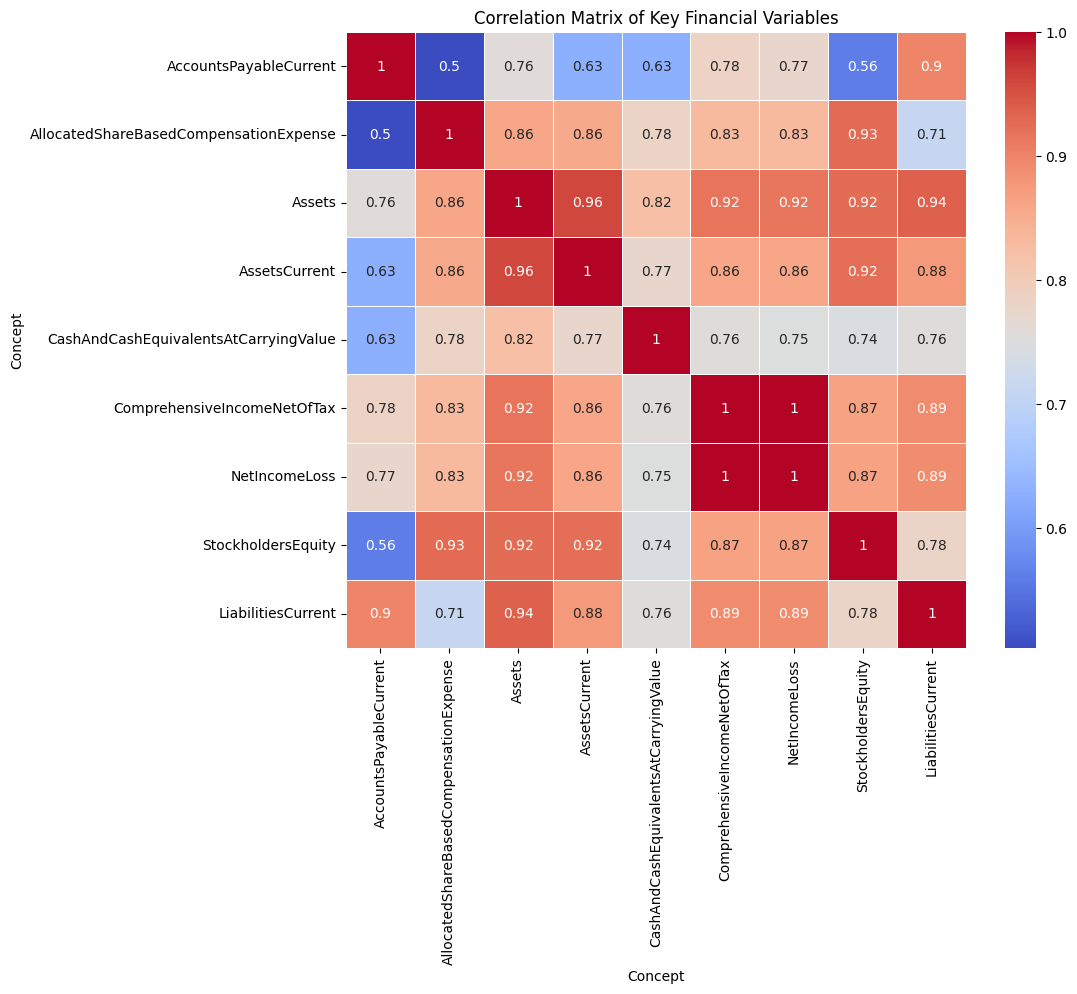

In [18]:
# Parameters we are interested in
columns = [
    'AccountsPayableCurrent', 'AllocatedShareBasedCompensationExpense', 'Assets', 'AssetsCurrent',
    'CashAndCashEquivalentsAtCarryingValue', 'ComprehensiveIncomeNetOfTax', 'NetIncomeLoss',
    'StockholdersEquity', 'LiabilitiesCurrent'
]

# Calculate the correlation matrix
correlation_matrix = transposed_df[columns].corr()

# Display the matrix
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Key Financial Variables')
plt.show()

Hypothesis Testing

In [19]:
# Filter for relevant concepts
rd_expense_df = unique_df[unique_df['Concept'] == 'AllocatedShareBasedCompensationExpense']
growth_df = unique_df[unique_df['Concept'] == 'StockholdersEquity']

# Merge the datasets on common identifiers
merged_df = pd.merge(rd_expense_df, growth_df, on=['Fiscal Year', 'Fiscal Period', 'entityName', 'cik'], suffixes=('_R&D', '_Growth'))

from scipy.stats import pearsonr

# Extract R&D expense and growth values
rd_expense = merged_df['Value_R&D']
growth = merged_df['Value_Growth']

# Perform Pearson correlation test
correlation, p_value = pearsonr(rd_expense, growth)

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant correlation between R&D investment and growth.")
else:
    print("Fail to reject the null hypothesis: No significant correlation between R&D investment and growth.")

Pearson Correlation Coefficient: 0.9276647940456075
P-value: 2.281303318764459e-154
Reject the null hypothesis: There is a significant correlation between R&D investment and growth.


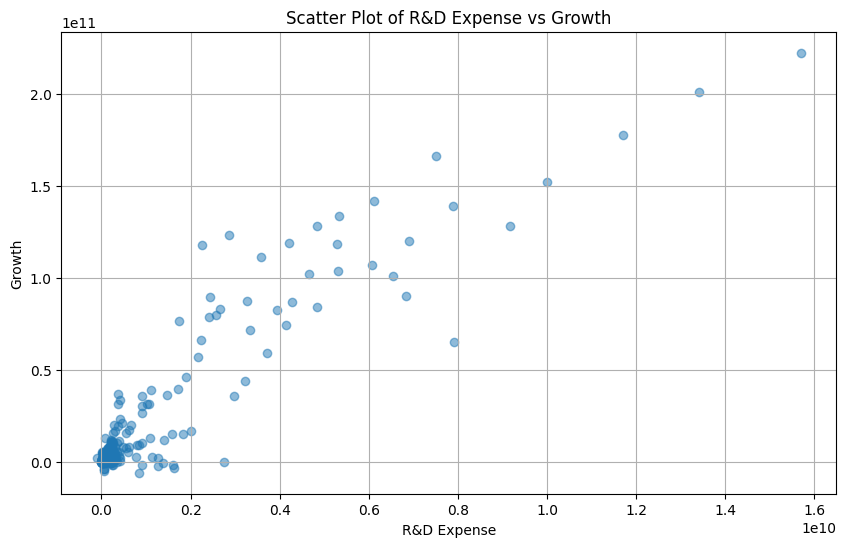

In [20]:
# Create a scatter plot for R&D expense and growth
plt.figure(figsize=(10, 6))
plt.scatter(rd_expense, growth, alpha=0.5)
plt.title('Scatter Plot of R&D Expense vs Growth')
plt.xlabel('R&D Expense')
plt.ylabel('Growth')
plt.grid(True)
plt.show()

Regression Analysis of Share Based Compensation and Stock Holder Equity

In [27]:
rd_expense_df = unique_df[unique_df['Concept'] == 'AllocatedShareBasedCompensationExpense']
growth_df = unique_df[unique_df['Concept'] == 'StockholdersEquity']

# Merge the datasets on common identifiers
merged_df = pd.merge(rd_expense_df, growth_df, on=['Fiscal Year', 'Fiscal Period', 'entityName', 'cik'], suffixes=('_R&D', '_Growth'))

import statsmodels.api as sm

# Perform regression analysis
X = merged_df['Value_R&D']
y = merged_df['Value_Growth']
X = sm.add_constant(X)  # Add a constant term for the intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Value_Growth   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     2197.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):          2.28e-154
Time:                        02:45:07   Log-Likelihood:                -8845.0
No. Observations:                 358   AIC:                         1.769e+04
Df Residuals:                     356   BIC:                         1.770e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.172e+09   7.41e+08      2.931      0.0

Anova testing

In [24]:
from statsmodels.formula.api import ols
import pandas as pd

import statsmodels.api as sm

# Prepare the data for ANOVA
anova_df = merged_df[['Value_R&D', 'Value_Growth']]

# Melt the dataframe to long format
anova_df_melt = pd.melt(anova_df.reset_index(), id_vars=['index'], value_vars=['Value_R&D', 'Value_Growth'])
anova_df_melt.columns = ['index', 'variable', 'value']

# Perform ANOVA
model = ols('value ~ C(variable)', data=anova_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                   sum_sq     df          F        PR(>F)
C(variable)  3.633001e+22    1.0  59.658581  3.824219e-14
Residual     4.348012e+23  714.0        NaN           NaN


In [25]:
# Result interpretation
if anova_table.loc['C(variable)', 'PR(>F)'] < 0.05:
    print("Reject the null hypothesis: There are significant differences between groups.")
else:
    print("Fail to reject the null hypothesis: No significant differences between groups.")

Reject the null hypothesis: There are significant differences between groups.
